In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [7]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_topics_all_news.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,_id,topic,heading,content,tags,processed_content,processed_topic
0,0,0,5f04d2481f35ed6864839349,"[""West-bengal""]","[""\n "",""\n ...","[""Garbage-lined streets and overflowing drains...","[""Garbage"",""Salt-lake"",""Bidhannagar-municipal-...",garbag line street overflow drain salt lake sp...,west bengal
1,1,1,5f04d24b1f35ed686483934a,"[""West-bengal""]","[""\n "",""\n ...","[""The Bengal government will set up a plasma b...","[""Calcutta-medical-college-and-hospital"",""Coro...",bengal govern plasma bank calcutta medic colle...,west bengal
2,2,2,5f04d24d1f35ed686483934b,"[""West-bengal""]","[""\n "",""\n ...","[""Bengal set another 24-hour record on Monday ...","[""Lockdown"",""Coronavirus"",""Quarantine""]",bengal hour record monday highest number covid...,west bengal
3,3,3,5f04d2501f35ed686483934c,"[""West-bengal""]","[""\n "",""\n ...","[""Chief minister Mamata Banerjee on Monday sai...","[""Mamata-banerjee"",""Cyclone-amphan""]",chief minist mamata banerje monday say problem...,west bengal
4,4,4,5f04d2531f35ed686483934d,"[""West-bengal""]","[""\n "",""\n ...","[""Some senior historians have raised questions...","[""Jagat-prakash-nadda"",""Bharatiya-janata-party...",senior historian rais question attempt pitch b...,west bengal


In [21]:
topic_names = df.processed_topic.unique()
len(topic_names)

50

In [22]:
num_docs = len(df.content)
num_docs

1274

In [57]:
texts = df.processed_content
target = np.array(df.processed_topic)
id2labels = {x[0]:x[1] for x in enumerate(topic_names)}

topic2id = {x[0]:x[1] for x in enumerate(target)}
len(id2labels)
id2labels

{0: 'west bengal',
 1: 'opinion',
 2: 'jharkhand',
 3: 'entertain',
 4: 'sport',
 5: 'busi',
 6: 'india',
 7: 'world',
 8: 'cultur',
 9: 'north east',
 10: 'coronavirus',
 11: 'citi',
 12: 'supplement',
 13: 'exclus interview',
 14: 'featur',
 15: 'lifestyl',
 16: 'analysi',
 17: 'editori',
 18: 'column',
 19: 'viral',
 20: 'mumbai',
 21: 'delhi',
 22: 'educ',
 23: 'bollywood',
 24: 'cricket',
 25: 'fashion trend',
 26: 'fit',
 27: 'music',
 28: 'footbal',
 29: 'travel',
 30: 'region movi',
 31: 'tenni',
 32: 'health',
 33: 'hollywood',
 34: 'relationship',
 35: 'scienc',
 36: 'gurugram',
 37: 'nation',
 38: 'intern',
 39: 'special',
 40: 'scienc environ',
 41: 'live',
 42: 'state',
 43: 'metrolif',
 44: 'spectrum',
 45: 'sunday herald',
 46: 'peopl',
 47: 'dhns',
 48: 'technolog',
 49: 'sunday chronicl'}

In [82]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

In [29]:
import collections
import nltk
#nltk.download('punkt')

#vocabulary
counter = collections.Counter()
for text in df.content:
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            counter[word] += 1
vocab_size = len([w for w, c in counter.most_common() if c >= 5])
print(vocab_size)

10465


In [27]:
VOCAB_FILE = '/content/drive/My Drive/ng-vocab.tsv'

In [31]:
fvocab = open(VOCAB_FILE, "w")
for word, count in counter.most_common():
    fvocab.write("{:s}\t{:d}\n".format(word, count))
fvocab.close()

In [34]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "r")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= 5:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 9138


In [61]:
#DATA_DIR = "../data"

#VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
#MIN_OCCURS = 5

GLOVE_FILE = '/content/drive/My Drive/glove.6B.300d.txt'
WORD_EMBED_SIZE = 300

NUM_CLASSES = 50
BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()


In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
WORD_EMBED_SIZE = 200

In [9]:
vocab_size = 10500

In [39]:
#Load GloVe embeddings

E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "r")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if word not in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(9138, 300)


In [ ]:
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() # not using list to avoid duplicate entry
        word2vector = {}
        for line in f:
            line_ = line.strip() #Remove white space
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [ ]:
#Compute Document Vectors

#ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
#num_docs = len(ng_data.data)
#print(num_docs)

In [73]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [75]:
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

In [77]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = texts[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(1274, 40, 60)


In [78]:
#actual labels
actual_labels = np.unique(target, return_inverse=True)[1]
#pd.factorize(df.processed_topic)[0]
actual_labels

array([48, 48, 48, ..., 29, 29, 29])

In [79]:
#Data Generation

y = actual_labels
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(1274, 50)


In [80]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(D, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(891, 300) (891, 50) (383, 300) (383, 50)


In [ ]:
#Define Network

In [64]:
inputs = Input(shape=(WORD_EMBED_SIZE, ))
fc1 = Dense(100, activation="relu")(inputs)
fc1_dropout = Dropout(0.2)(fc1)
fc2 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc2)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc1_dropout)

In [84]:
WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

In [85]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE))(sent_emb)

sent_encoder = Model(inputs=sent_inputs, outputs=sent_enc)
sent_encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 300)           2741400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 2,982,000
Trainable params: 2,982,000
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [87]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 801 samples, validate on 90 samples
Epoch 1/10
801/801 [==============================] - 0s 166us/step - loss: 2.7707 - accuracy: 0.2871 - val_loss: 2.8639 - val_accuracy: 0.3111
Epoch 2/10
801/801 [==============================] - 0s 41us/step - loss: 2.6872 - accuracy: 0.3096 - val_loss: 2.8224 - val_accuracy: 0.3333
Epoch 3/10
801/801 [==============================] - 0s 49us/step - loss: 2.6395 - accuracy: 0.3121 - val_loss: 2.7965 - val_accuracy: 0.3222
Epoch 4/10
801/801 [==============================] - 0s 42us/step - loss: 2.5967 - accuracy: 0.3258 - val_loss: 2.7478 - val_accuracy: 0.3333
Epoch 5/10
801/801 [==============================] - 0s 45us/step - loss: 2.5438 - accuracy: 0.3358 - val_loss: 2.7148 - val_accuracy: 0.3222
Epoch 6/10
801/801 [==============================] - 0s 45us/step - loss: 2.5112 - accuracy: 0.3346 - val_loss: 2.6905 - val_accuracy: 0.3111
Epoch 7/10
801/801 [==============================] - 0s 45us/step - loss: 2.4756 - accuracy: 0.

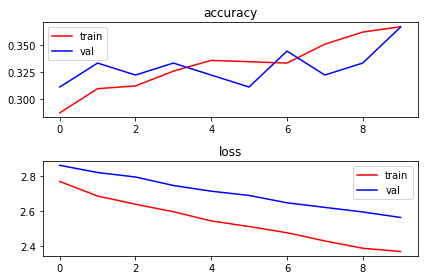

In [88]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
#Evaluate Network

In [89]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.426

confusion matrix

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 32 ...  0  0  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  2 ...  0  0 15]]
